In [118]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import tqdm
import random
import re
from scipy.stats import ks_2samp


In [3]:
def umap_distance(rv_1, rv_2, df_umap):
    x1 = df_umap[df_umap.Rv_ID == rv_1].u1.values[0]
    y1 = df_umap[df_umap.Rv_ID == rv_1].u2.values[0]
    x2 = df_umap[df_umap.Rv_ID == rv_2].u1.values[0]
    y2 = df_umap[df_umap.Rv_ID == rv_2].u2.values[0]
    return np.sqrt( (x1 - x2)**2 + (y1 - y2)**2 )

In [87]:
def shuffle_genes(df_not_shuffled):
    ### shuffling of genes with respect to UMAP coordinates:
    cols_genes = df_not_shuffled.columns[:4]
    cols_umap = df_not_shuffled.columns[4:]

    df_genes = df_not_shuffled[cols_genes].copy()
    df_umap = df_not_shuffled[cols_umap].copy()

    df_genes_shuffle = df_genes.reindex(np.random.permutation(df_genes.index)).reset_index(drop = True)
    df_shuffle = pd.concat([df_genes_shuffle, df_umap], axis=1)
    
    return df_shuffle

In [88]:
df = pd.read_csv('../../data/tests/df_umap.csv')
df.head(2)

,Rv_ID,gene_name,func_tuberculist,COG,u1,u2,u3
0,Rv0003,recF,information pathways,L,-16.680069,-2.016419,10.354388
1,Rv0007,-,cell wall and cell processes,S,-11.018177,-2.696438,12.063074


In [10]:
rv_1 = 'Rv0003'
rv_2 = 'Rv0007'
umap_distance(rv_1, rv_2, df)

5.702582484807108

In [109]:
list_rv_id = df.Rv_ID.to_list()
list_rv_id = [rv for rv in list_rv_id if 'Rvnr' not in rv]
list_int_rv_id = [int(re.split( 'c|A|B|D' , rv.split('Rv')[1] )[0]) for rv in list_rv_id]

In [110]:
window_size = 3
list_pairs = [(ind_list[i], ind_list[j]) for i in range(len(ind_list)) for j in range(i+1,len(ind_list)) 
 if np.abs(list_int_rv_id[i] - list_int_rv_id[j]) <= window_size]

In [111]:
len(list_pairs)

2232

In [112]:
list_dist = []
for rv_pair in tqdm.tqdm(list_pairs):
    list_dist.append(umap_distance( list_rv_id[rv_pair[0]], list_rv_id[rv_pair[1]], df))

100%|██████████| 2232/2232 [00:08<00:00, 267.90it/s]


In [113]:
num_iter = 2232
list_dist_rand = []
for i in range(num_iter):
    rvid_pair = random.sample(list_rv_id, 2)
    list_dist_rand.append(umap_distance( rvid_pair[0], rvid_pair[1], df))

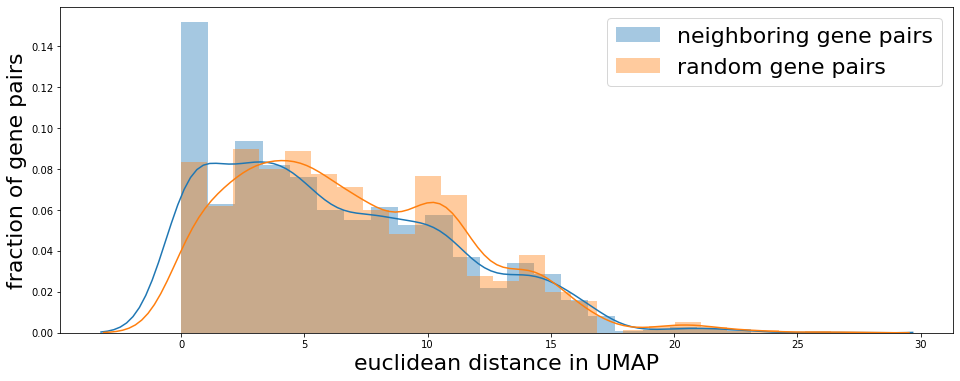

In [114]:
plt.figure(figsize = (16,6))
sns.distplot(list_dist)
sns.distplot(list_dist_rand)
plt.legend(['neighboring gene pairs', 'random gene pairs'], fontsize = 22)
plt.xlabel('euclidean distance in UMAP', fontsize = 22)
plt.ylabel('fraction of gene pairs', fontsize = 22)
plt.savefig('../../figures/pairwise_distances/umap_vs_genome_w3.png', dpi=300)

In [115]:
ks_2samp(list_dist, list_dist_rand)

Ks_2sampResult(statistic=0.09005376344086022, pvalue=2.698098410873525e-08)

In [104]:
len([d for d in list_dist if d<=0.25]) / len(list_dist)

0.09453405017921147

In [105]:
len([d for d in list_dist_rand if d<=0.25]) / len(list_dist)

0.02956989247311828

### Compare to shuffled data:

In [116]:
df_shuffled = shuffle_genes(df)

In [117]:
list_dist_shuffled = []
for rv_pair in tqdm.tqdm(list_pairs):
    list_dist_shuffled.append(umap_distance( list_rv_id[rv_pair[0]], list_rv_id[rv_pair[1]], df_shuffled))

100%|██████████| 2232/2232 [00:08<00:00, 272.99it/s]


Text(0, 0.5, 'fraction of gene pairs')

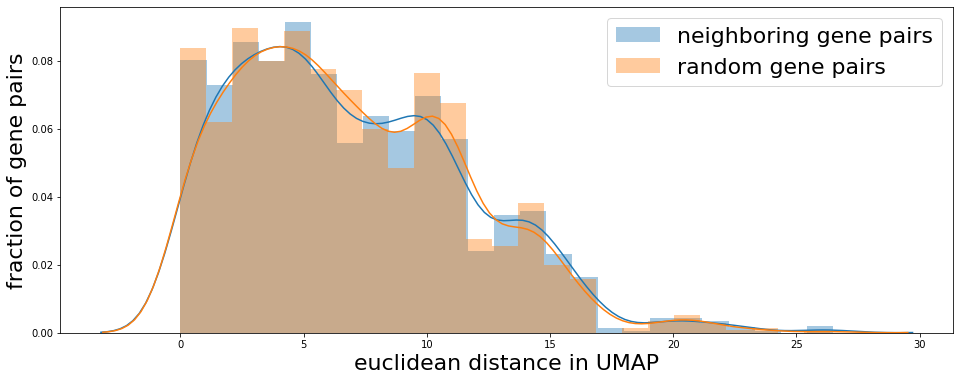

In [120]:
plt.figure(figsize = (16,6))
sns.distplot(list_dist_shuffled)
sns.distplot(list_dist_rand)
plt.legend(['neighboring gene pairs', 'random gene pairs'], fontsize = 22)
plt.xlabel('euclidean distance in UMAP', fontsize = 22)
plt.ylabel('fraction of gene pairs', fontsize = 22)
# plt.savefig('../../figures/pairwise_distances/umap_vs_genome_w3.png', dpi=300)

In [122]:
ks_2samp(list_dist_shuffled, list_dist_rand)

Ks_2sampResult(statistic=0.01747311827956989, pvalue=0.8851866891353868)